# **Machine Learning Project Using ARIMA and K-Means**

## 1. Import Library

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as scp
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import normaltest
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 2. Import Dataset

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
df = pd.read_csv('transaction.csv', delimiter=';', error_bad_lines=False, warn_bad_lines=True)
df.head(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [7]:
df.tail(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
5015,TR54423,243,31/12/2022,P10,15000,5,75000,3
5016,TR5604,271,31/12/2022,P2,3200,4,12800,9
5017,TR81224,52,31/12/2022,P7,9400,6,56400,9
5018,TR85016,18,31/12/2022,P8,16000,3,48000,13
5019,TR85684,55,31/12/2022,P8,16000,1,16000,6


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


## 3. Data Preprocessing

### 3.1 Changing the Appropriate Data Type

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 313.9+ KB


### 3.2 Handling Duplicated Data

In [10]:
# Check for duplicate data
df.duplicated().sum()

0

### 3.3 Handling Missing Value

In [11]:
# Check for missing values
def check_null(df) :
    col_na = df.isnull().sum().sort_values(ascending=False)
    percent = round((col_na/len(df))*100,3)
    missing_data = pd.concat([col_na, percent],axis=1, keys=['Total Missing Values','Percentage(%)'])
    print(missing_data[missing_data['Total Missing Values'] > 0])

In [12]:
check_null(df) 

Empty DataFrame
Columns: [Total Missing Values, Percentage(%)]
Index: []


### 3.4 Data For Machine Learning Modeling

#### 3.4.1 Inventory Data

In [13]:
df_inventory = df[['Date','Qty']]
df_inventory = df_inventory.groupby('Date')['Qty'].sum().reset_index()
df_inventory = df_inventory.sort_values(by='Date')
df_inventory.head()

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67


In [14]:
df_inventory.tail()

,Date,Qty
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44
364,2022-12-31,37


#### 3.4.2 Marketing Data

In [15]:
df_marketing= df.groupby('CustomerID').agg(
                                    Total_Transaction = pd.NamedAgg(column='TransactionID', aggfunc='count'),
                                    Total_Quantity = pd.NamedAgg(column='Qty', aggfunc='sum'),
                                    Total_Amount = pd.NamedAgg(column='TotalAmount', aggfunc='sum')).reset_index()
df_marketing = df_marketing.sort_values(by = 'CustomerID', ascending = True)
df_marketing.head()

,CustomerID,Total_Transaction,Total_Quantity,Total_Amount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [16]:
df_marketing.tail()

,CustomerID,Total_Transaction,Total_Quantity,Total_Amount
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300
446,447,13,42,439300


## 4. Exploratory Data Analysis (EDA)

### 4.1 EDA Inventory Data

In [17]:
df_inventory.head()

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67


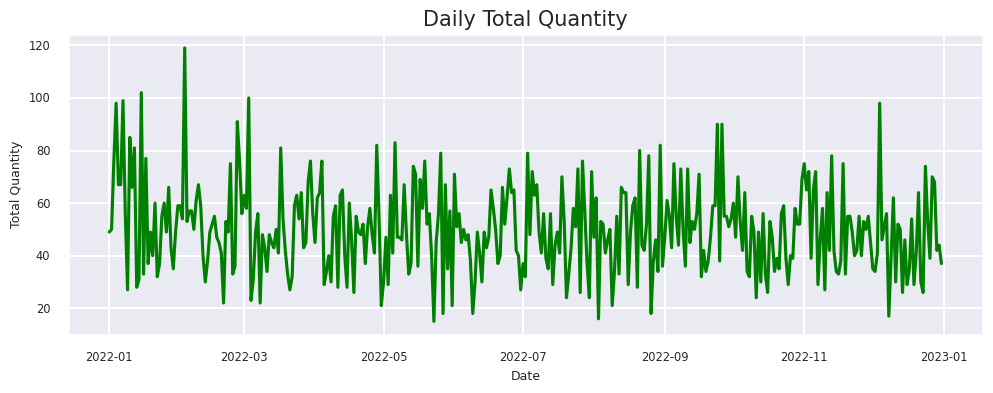

In [18]:
# Time Series Plot Daily Total Quantity
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,4))
    sns.lineplot(x=df_inventory['Date'], y=df_inventory['Qty'], color='green')
    plt.title('Daily Total Quantity', fontsize = 15)
    plt.xlabel('Date')
    plt.ylabel('Total Quantity')
    
plt.tight_layout()
plt.show()

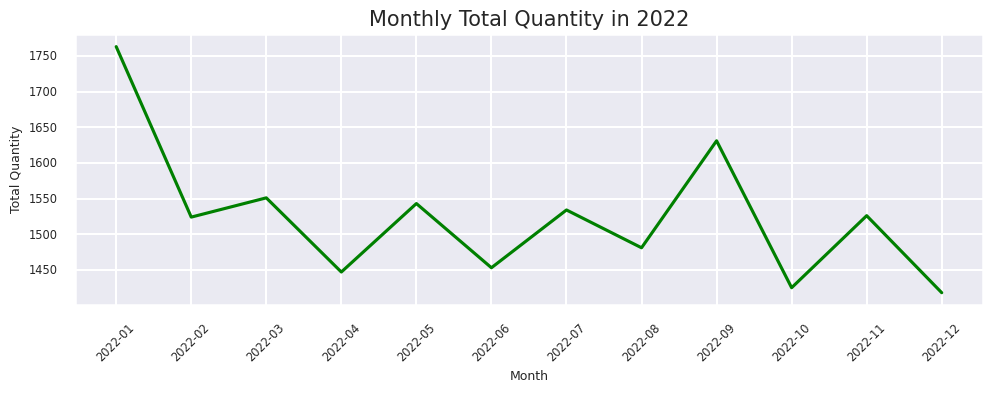

In [19]:
df_inventory['Month'] = df_inventory['Date'].dt.strftime('%Y-%m')
df_inventory_monthly = df_inventory.groupby('Month')['Qty'].sum().reset_index()

# Time Series Plot Monthly Total Quantity
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(x=df_inventory_monthly['Month'], y=df_inventory_monthly['Qty'], color='green')
    ax.set_title('Monthly Total Quantity in 2022', fontsize=15)
    plt.xlabel('Month')
    plt.ylabel('Total Quantity')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()

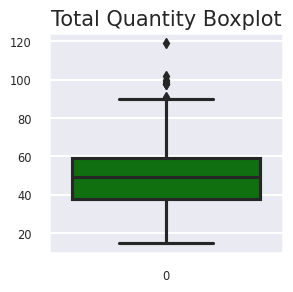

In [20]:
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    plt.subplots(figsize=(3,3))
    sns.boxplot(data=df_inventory['Qty'], color='green')
    plt.title('Total Quantity Boxplot', fontsize = 15)

plt.tight_layout()
plt.show()

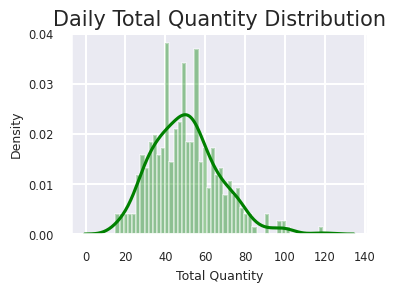

In [21]:
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(4,3))
    sns.distplot(df_inventory['Qty'], norm_hist=True, color='green',bins=50)
    plt.title('Daily Total Quantity Distribution', fontsize = 15)
    plt.xlabel('Total Quantity')
    
plt.tight_layout()
plt.show()

In [22]:
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

In [23]:
round(describe(df_inventory, ['skew', 'kurt']),2)

,Qty
count,365.00
mean,50.13
std,16.70
min,15.00
25%,38.00
50%,49.00
75%,59.00
max,119.00
skew,0.59
kurt,0.68


In [24]:
Qty_max = df_inventory[df_inventory['Qty'] == df_inventory['Qty'].max()]
Qty_min = df_inventory[df_inventory['Qty'] == df_inventory['Qty'].min()]
print(Qty_max)
print(Qty_min)

         Date  Qty    Month
33 2022-02-03  119  2022-02
          Date  Qty    Month
142 2022-05-23   15  2022-05


### 4.2 EDA Marketing Data

In [25]:
df_marketing.head()

,CustomerID,Total_Transaction,Total_Quantity,Total_Amount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [26]:
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 0 to 446
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   CustomerID         447 non-null    int64
 1   Total_Transaction  447 non-null    int64
 2   Total_Quantity     447 non-null    int64
 3   Total_Amount       447 non-null    int64
dtypes: int64(4)
memory usage: 17.5 KB


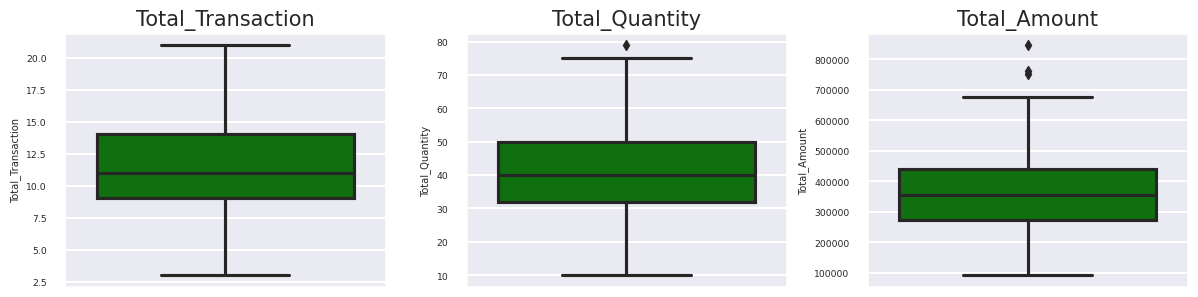

In [27]:
cols = ['Total_Transaction','Total_Quantity','Total_Amount']

plt.figure(figsize=(12, 3))
sns.set_context("talk", font_scale=0.4)
with sns.axes_style("darkgrid"):
    for i, col in enumerate(cols, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(data=df_marketing, y=col, color='green', orient='v')
        plt.title(f'{col}', fontsize=15)

plt.tight_layout()
plt.show()

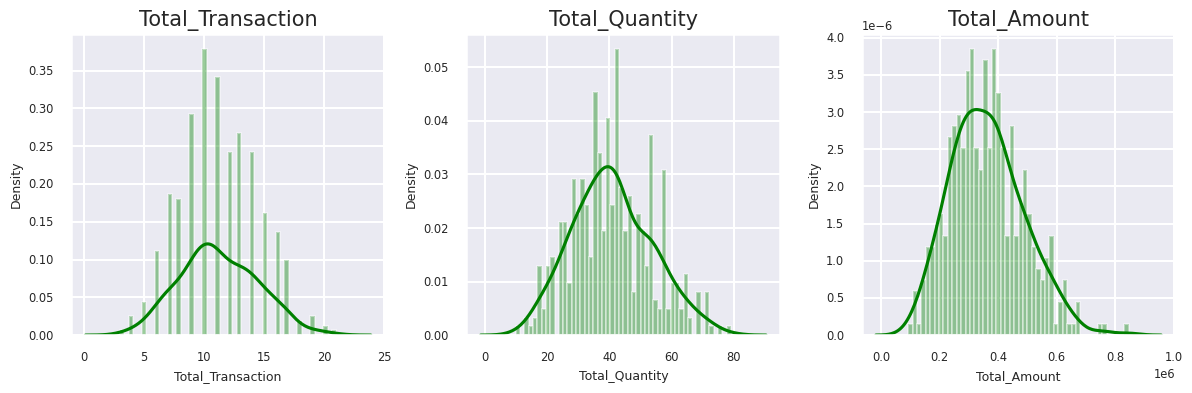

In [28]:
plt.figure(figsize=(12, 4))
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    for i, col in enumerate(cols, 1):
        plt.subplot(1, 3, i)
        sns.distplot(df_marketing[col], color='green', bins=50)
        plt.title(f'{col}', fontsize=15)

plt.tight_layout() 
plt.show()

In [29]:
round(describe(df_marketing[['Total_Transaction','Total_Quantity','Total_Amount']], ['skew', 'kurt']),2)

,Total_Transaction,Total_Quantity,Total_Amount
count,447.00,447.00,447.00
mean,11.23,40.93,362512.30
std,3.25,12.76,124634.28
min,3.00,10.00,92100.00
25%,9.00,32.00,271750.00
50%,11.00,40.00,354200.00
75%,14.00,50.00,441200.00
max,21.00,79.00,846700.00
skew,0.18,0.26,0.47
kurt,-0.31,-0.26,0.16


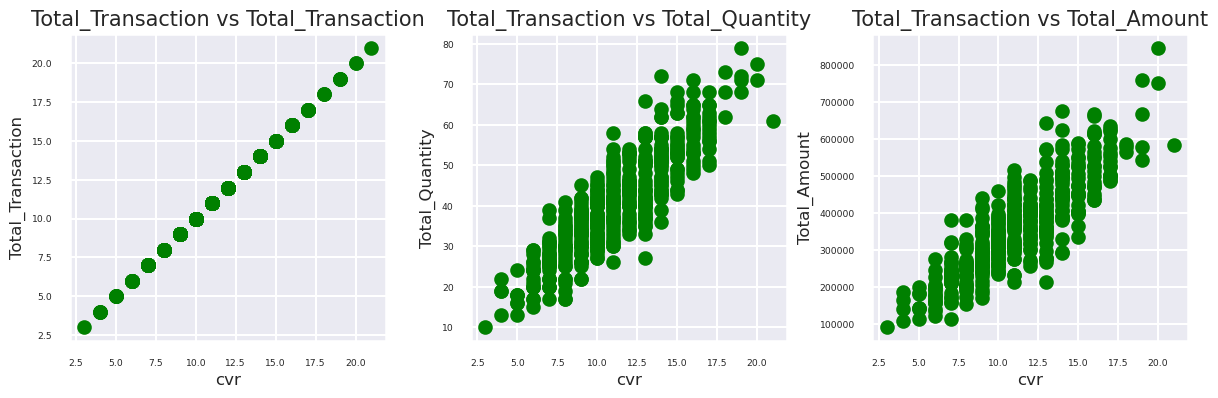

In [30]:
plt.figure(figsize=(12, 4))
sns.set_context("talk", font_scale=0.4)
with sns.axes_style("darkgrid"):
    for i, col in enumerate(cols, 1):
        plt.subplot(1, 3, i)
        plt.scatter(df_marketing['Total_Transaction'], df_marketing[col], c='green')
        plt.ylabel(f'{col}', fontsize=12)
        plt.xlabel('cvr', fontsize=12)
        plt.title(f'Total_Transaction vs {col}', fontsize=15)
        
plt.tight_layout()
plt.show()

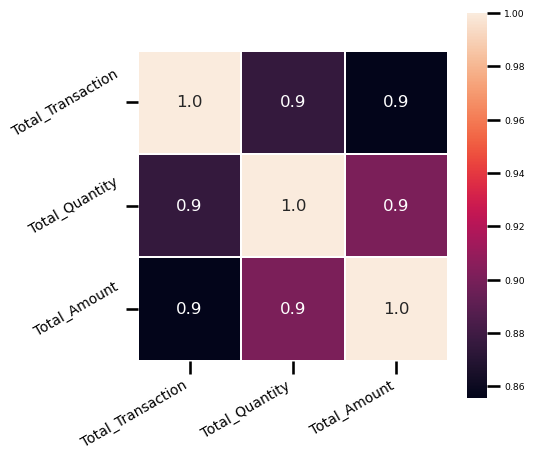

In [31]:
plt.figure(figsize=(5, 5))
corrmat = df_marketing[cols].corr()
sns.heatmap(corrmat, annot=True, fmt='.1f', vmin=corrmat.values.min(), vmax=1, square=True,
            linewidths=0.1, annot_kws={"fontsize":12})
plt.xticks(rotation = 30, horizontalalignment = 'right', fontsize = 10)
plt.yticks(rotation = 30, fontsize = 10)
plt.show()

## 5. Machine Learning Modeling

### 5.1 ARIMA Modeling

#### 5.1.1 Training Data and Testing Data

In [32]:
train_size = int(len(df_inventory) * 0.9)
train = df_inventory[:train_size]
test = df_inventory[train_size:]

In [33]:
#train = df_inventory.iloc[:292]
#test = df_inventory.iloc[292:]

In [34]:
train.shape

(328, 3)

In [35]:
test.shape

(37, 3)

#### 5.1.2 Augmented Dickey Fuller (ADF) Test

In [36]:
def adf_test(data):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] > 0.05:
        print('Conclusion : Non - Stationary Data')
    else:
        print('Conclusion : Stasionary Data')

In [37]:
print('ADF test Total Quantity')
print(adf_test(train['Qty']))

ADF test Total Quantity
ADF Statistic: -17.978891
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572
Conclusion : Stasionary Data
None


#### 5.1.3 Identify Autocorrelation Function (ACF) Plot  and Partial Autocorrelation Function  (PACF) Plot

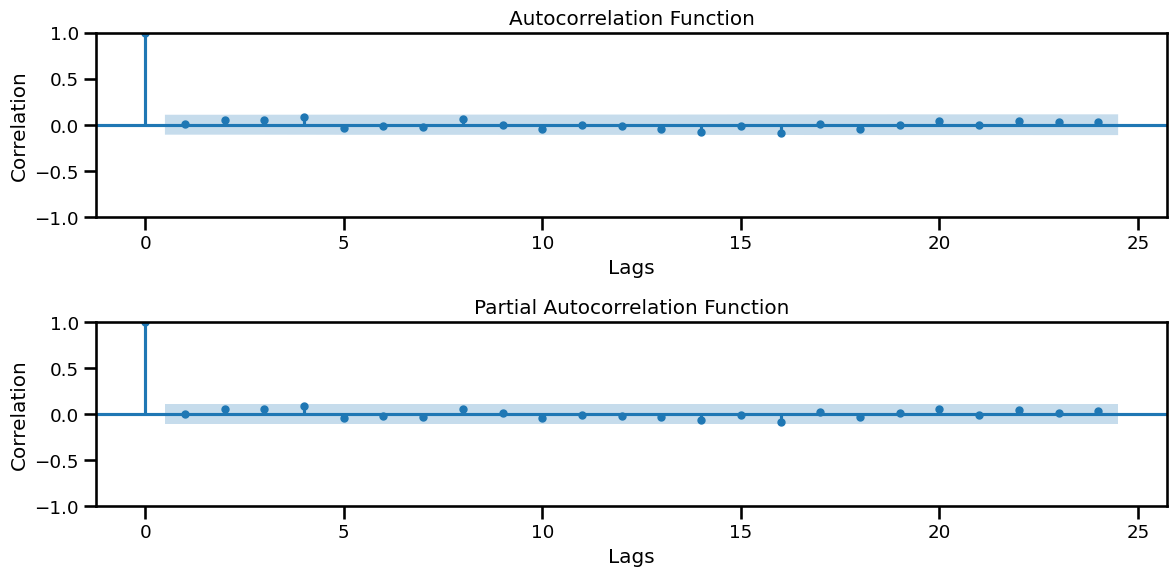

In [38]:
sns.set_context("talk", font_scale=0.8)
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,6))
acf = plot_acf(train['Qty'],lags=24,ax=ax1)
ax1.set_title('Autocorrelation Function')
acf = plot_pacf(train['Qty'],lags=24,ax=ax2)
ax2.set_title('Partial Autocorrelation Function')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout()
plt.show()

#### 5.1.4 Model Identification

###### 1. ARIMA (1,0,0) Model

In [39]:
p = 1 
d = 0 
q = 0
model1 = sm.tsa.ARIMA(train['Qty'], order=(p, d, q))
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  328
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1389.711
Date:                Sat, 23 Sep 2023   AIC                           2785.423
Time:                        17:46:31   BIC                           2796.802
Sample:                             0   HQIC                          2789.963
                                - 328                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5487      0.989     51.129      0.000      48.611      52.486
ar.L1          0.0023      0.056      0.042      0.967      -0.107       0.112
sigma2       280.3312     20.482     13.687      0.000     240.188     320.475
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                22.20
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.56
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There are parameters that are not significant

##### 2. ARIMA (0,0,1) Model

In [40]:
p = 0
d = 0 
q = 1
model2 = sm.tsa.ARIMA(train['Qty'], order=(p, d, q))
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  328
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1389.711
Date:                Sat, 23 Sep 2023   AIC                           2785.423
Time:                        17:46:31   BIC                           2796.802
Sample:                             0   HQIC                          2789.963
                                - 328                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5487      0.988     51.142      0.000      48.612      52.486
ma.L1          0.0021      0.056      0.037      0.970      -0.107       0.112
sigma2       280.3369     20.483     13.686      0.000     240.191     320.482
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                22.20
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.56
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There are parameters that are not significant

##### 3. ARIMA (1,0,1) Model

In [41]:
p = 1
d = 0 
q = 1
model3 = sm.tsa.ARIMA(train['Qty'], order=(p, d, q))
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  328
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1389.026
Date:                Sat, 23 Sep 2023   AIC                           2786.051
Time:                        17:46:31   BIC                           2801.223
Sample:                             0   HQIC                          2792.105
                                - 328                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5508      0.981     51.539      0.000      48.628      52.473
ar.L1         -0.9859      0.036    -27.550      0.000      -1.056      -0.916
ma.L1          0.9757      0.047     20.669      0.000       0.883       1.068
sigma2       279.1198     20.350     13.716      0.000     239.235     319.004
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                23.82
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.57
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

All parameters are significant

##### 4. ARIMA (2,0,2) Model

In [42]:
p = 2
d = 0 
q = 2
model4 = sm.tsa.ARIMA(train['Qty'], order=(p, d, q))
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  328
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1388.035
Date:                Sat, 23 Sep 2023   AIC                           2788.070
Time:                        17:46:32   BIC                           2810.828
Sample:                             0   HQIC                          2797.150
                                - 328                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5416      1.064     47.481      0.000      48.455      52.628
ar.L1          0.9073      0.346      2.620      0.009       0.229       1.586
ar.L2         -0.6026      0.333     -1.812      0.070      -1.255       0.049
ma.L1         -0.9253      0.319     -2.901      0.004      -1.551      -0.300
ma.L2          0.6782      0.304      2.230      0.026       0.082       1.274
sigma2       277.4442     21.746     12.759      0.000     234.823     320.065
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                16.58
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.51
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There are parameters that are not significant

##### 5. ARIMA (3,0,3) Model

In [43]:
p = 3
d = 0 
q = 3
model5 = sm.tsa.ARIMA(train['Qty'], order=(p, d, q))
results5 = model5.fit()
results5.summary()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  328
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1386.940
Date:                Sat, 23 Sep 2023   AIC                           2789.879
Time:                        17:46:32   BIC                           2820.223
Sample:                             0   HQIC                          2801.986
                                - 328                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5905      1.041     48.589      0.000      48.550      52.631
ar.L1          0.0743      0.091      0.819      0.413      -0.103       0.252
ar.L2          0.1573      0.097      1.618      0.106      -0.033       0.348
ar.L3         -0.8894      0.091     -9.798      0.000      -1.067      -0.711
ma.L1         -0.0991      0.082     -1.214      0.225      -0.259       0.061
ma.L2         -0.1209      0.086     -1.411      0.158      -0.289       0.047
ma.L3          0.9307      0.080     11.695      0.000       0.775       1.087
sigma2       282.5913     22.977     12.299      0.000     237.557     327.625
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                16.77
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.51
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There are parameters that are not significant

##### 6. ARIMA (4,0,4) Model

In [44]:
p = 4
d = 0 
q = 4
model6 = sm.tsa.ARIMA(train['Qty'], order=(p, d, q))
results6 = model6.fit()
results6.summary()

C:\Users\User\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  328
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -1386.875
Date:                Sat, 23 Sep 2023   AIC                           2793.749
Time:                        17:46:33   BIC                           2831.680
Sample:                             0   HQIC                          2808.883
                                - 328                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.5518      1.156     43.737      0.000      48.286      52.817
ar.L1         -0.0595      0.560     -0.106      0.915      -1.158       1.039
ar.L2         -0.2578      0.463     -0.557      0.577      -1.165       0.649
ar.L3         -0.3240      0.466     -0.695      0.487      -1.237       0.589
ar.L4          0.2307      0.505      0.457      0.648      -0.760       1.221
ma.L1          0.0563      0.571      0.099      0.921      -1.062       1.175
ma.L2          0.3154      0.471      0.670      0.503      -0.607       1.238
ma.L3          0.3818      0.478      0.799      0.424      -0.554       1.318
ma.L4         -0.1311      0.543     -0.241      0.809      -1.196       0.934
sigma2       275.5148     21.906     12.577      0.000     232.579     318.450
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.53
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.51
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

There are parameters that are not significant

**Significant Model Selection**

Based on the significance of the parameters, there is 1 model that has all significant parameters, namely the ARIMA (1,0,1) model. In this project the ARIMA (1,0,1) model was chosen because only this model has significant parameters

#### 5.1.5 Diagnostic Test

##### 1. White Noise Test

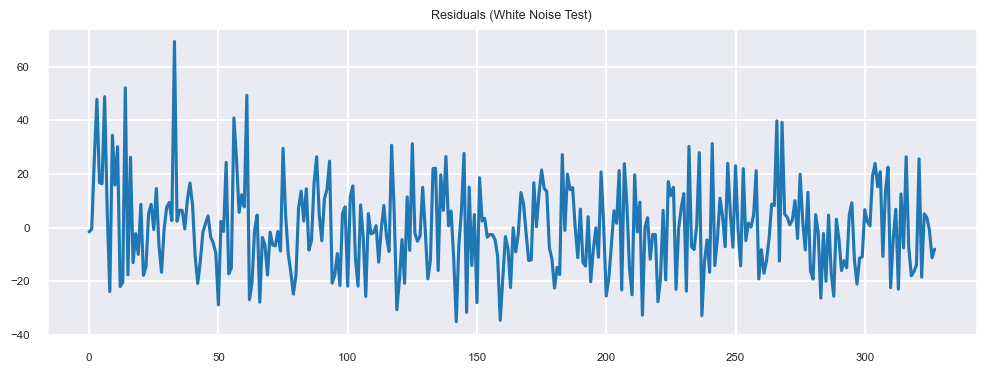

In [45]:
residuals = results3.resid

sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 4))
    plt.plot(residuals)
    plt.title('Residuals (White Noise Test)')
    plt.show()

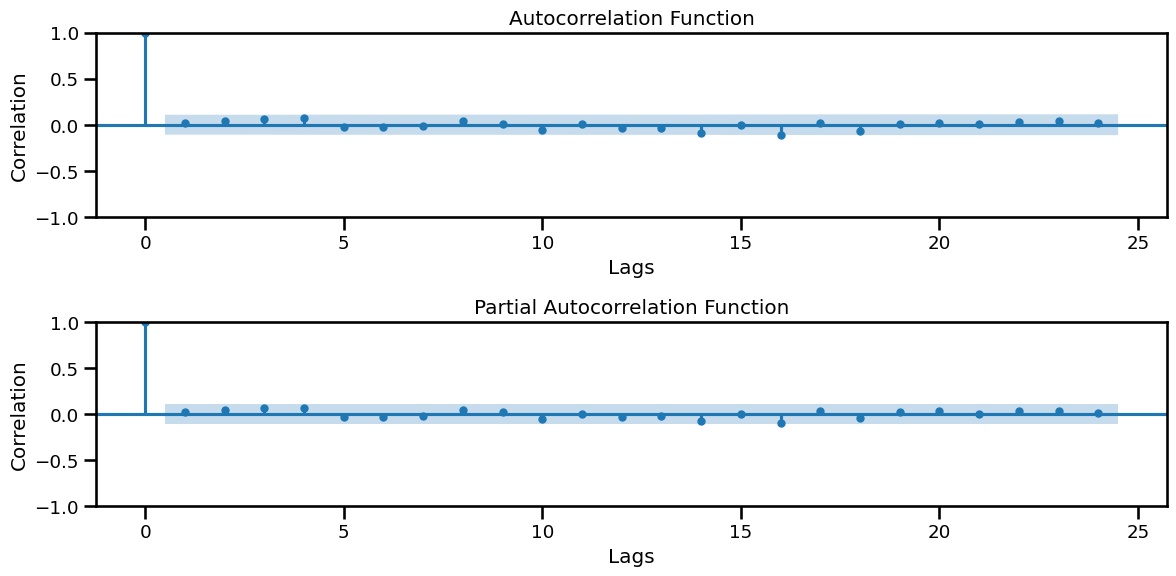

In [46]:
sns.set_context("talk", font_scale=0.8)
fig,(ax1,ax2) = plt.subplots(2,figsize=(12,6))
acf = plot_acf(residuals,lags=24,ax=ax1)
ax1.set_title('Autocorrelation Function')
acf = plot_pacf(residuals,lags=24,ax=ax2)
ax2.set_title('Partial Autocorrelation Function')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout()
plt.show()

Lower lags barely show any significant 'spikes'. This indicates that the residuals are close to white noise. It can be concluded that ARIMA (4,0,4) meets the white noise assumption.

##### 2. Normalitity Test

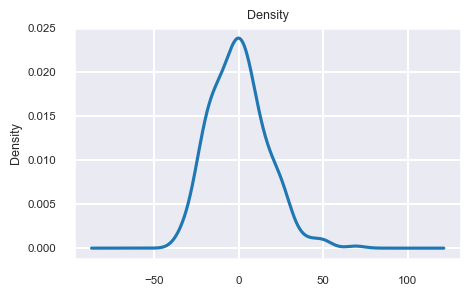

In [47]:
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    residuals.plot(figsize=(5,3),title='Density', kind='kde')
    plt.show()

In [48]:

p_value = normaltest(residuals)[1]
if p_value < 0.05:
    print("Residuals are not normally distributed (p-value < 0.05)")
else:
    print("Residuals are normally distributed (p-value >= 0.05)")


Residuals are not normally distributed (p-value < 0.05)


The results of the normality test on the residuals show that the ARIMA residuals (4,0,4) are not normally distributed

#### 5.1.6 Forecasting Total Quantity Using Best Model

In [49]:
forecast = results3.forecast(steps=len(test))
test['forecast'] = forecast

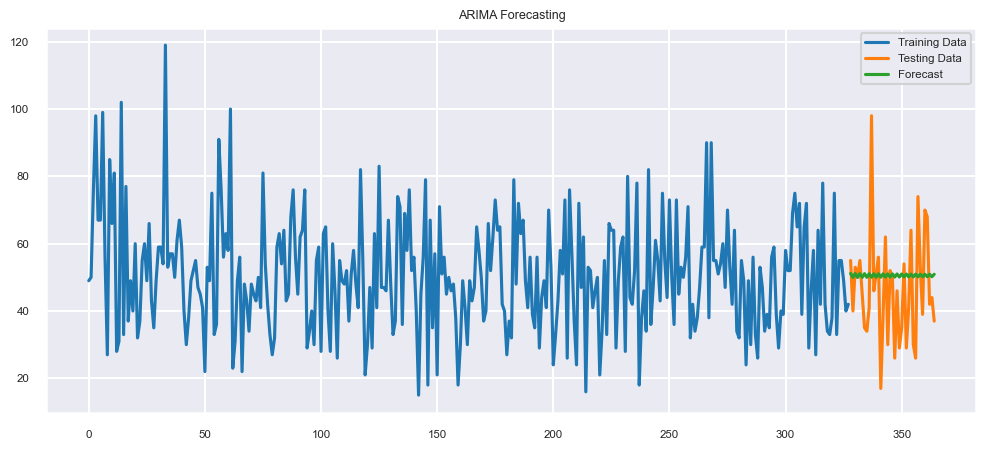

In [50]:
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12, 5))
    plt.plot(train['Qty'], label='Training Data')
    plt.plot(test['Qty'], label='Testing Data')
    plt.plot(test['forecast'], label='Forecast', linestyle='-')
    plt.legend()
    plt.title('ARIMA Forecasting')
    plt.show()

In [51]:
mae = mean_absolute_error(test['Qty'], forecast)
mape = mean_absolute_percentage_error(test['Qty'], forecast)
rmse = np.sqrt(mean_squared_error(test['Qty'], forecast))

print(f'MAE  : {mae}')
print(f'MAPE : {mape}')
print(f'RMSE : {rmse}')

MAE  : 12.675885484467079
MAPE : 0.3416714532952726
RMSE : 16.21730311234308


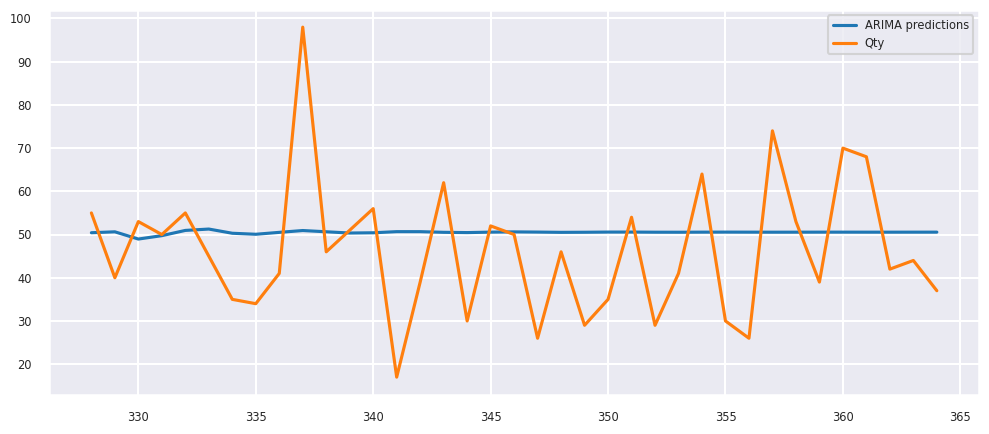

In [52]:
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    start=len(train)
    end=len(train)+len(test)-1
    pred=results6.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
    pred.plot(figsize=(12,5),legend=True)
    test['Qty'].plot(legend=True)

In [53]:
index_future_dates=pd.date_range(start='2023-01-01',end='2023-01-31')
#print(index_future_dates)
pred=results6.predict(start=len(df_inventory),end=len(df_inventory)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
print(pred)

2023-01-01    50.552172
2023-01-02    50.550335
2023-01-03    50.551176
2023-01-04    50.552628
2023-01-05    50.552485
2023-01-06    50.551423
2023-01-07    50.551247
2023-01-08    50.551912
2023-01-09    50.552229
2023-01-10    50.551851
2023-01-11    50.551535
2023-01-12    50.551703
2023-01-13    50.551970
2023-01-14    50.551926
2023-01-15    50.551732
2023-01-16    50.551707
2023-01-17    50.551835
2023-01-18    50.551886
2023-01-19    50.551814
2023-01-20    50.551758
2023-01-21    50.551792
2023-01-22    50.551840
2023-01-23    50.551830
2023-01-24    50.551794
2023-01-25    50.551791
2023-01-26    50.551815
2023-01-27    50.551823
2023-01-28    50.551809
2023-01-29    50.551800
2023-01-30    50.551807
2023-01-31    50.551815
Freq: D, Name: ARIMA Predictions, dtype: float64


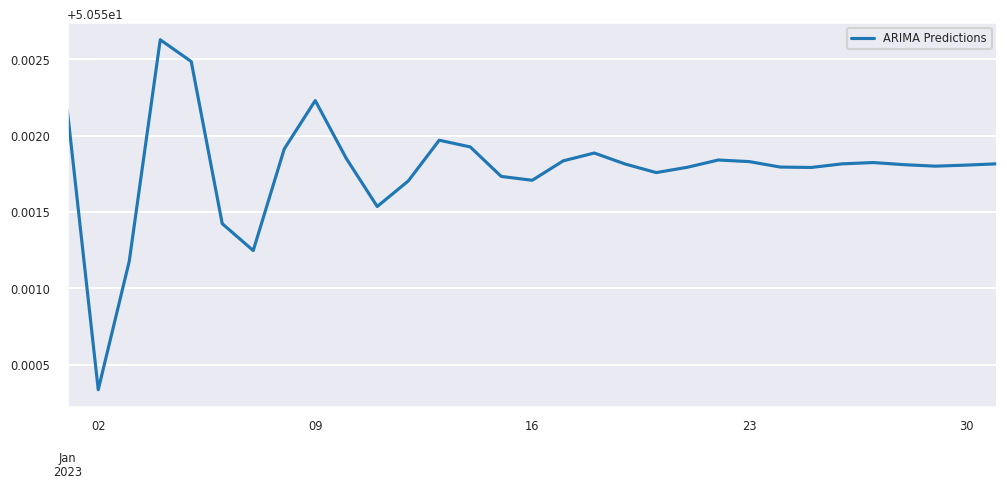

In [54]:
sns.set_context("talk", font_scale=0.5)
with sns.axes_style("darkgrid"):
    pred.plot(figsize=(12,5),legend=True)

### 5.2 K-Means Modeling

#### 5.2.1 Data Standardization

In [55]:
df_marketing.drop(columns = ['CustomerID'], inplace=True)
df_marketing.head()

,Total_Transaction,Total_Quantity,Total_Amount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


In [56]:
df_scaled = df_marketing.copy()
ss = StandardScaler()

In [57]:
df_scaled = ss.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled, columns = df_marketing.columns)
round(df_scaled,2).head()

,Total_Transaction,Total_Quantity,Total_Amount
0,1.78,1.50,2.09
1,0.55,1.26,0.24
2,1.16,1.18,0.67
3,-0.38,0.40,-0.48
4,-1.31,-1.09,-0.75


#### 5.2.2 Determining the Optimal Number of Clusters

In [58]:
inertia = []

for i in range(1, 8):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=142)
    kmeans.fit(df_scaled.values)
    inertia.append(kmeans.inertia_)

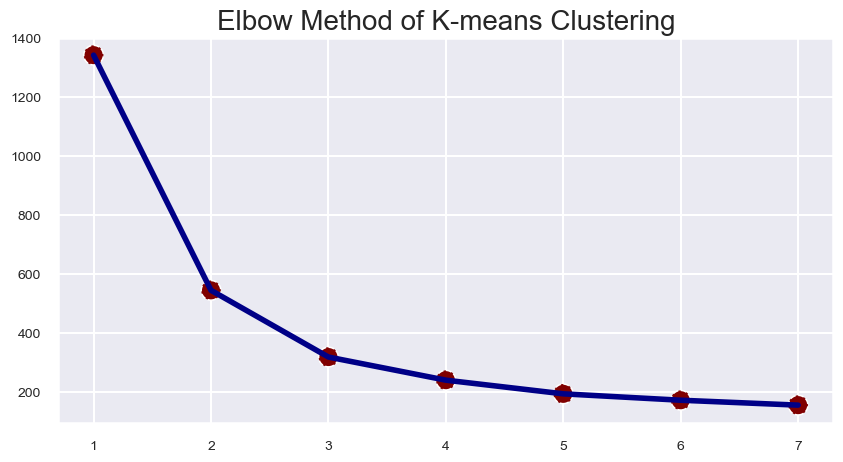

In [59]:
plt.figure(figsize=(10, 5))
sns.set_context("talk", font_scale=0.4)
with sns.axes_style("darkgrid"):
    plt.title('Elbow Method of K-means Clustering', fontsize = 20)
    sns.lineplot(x=range(1, 8), y=inertia, color='#000087', linewidth = 4)
    sns.scatterplot(x=range(1, 8), y=inertia, s=200, color='#800000',  linestyle='--')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [60]:
from sklearn.metrics import silhouette_score

def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=142)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=1, fmt='.3f', cmap='RdYlGn')
    plt.tight_layout()
    plt.title('Silhouette Score of K-means Clustering')
    plt.show()

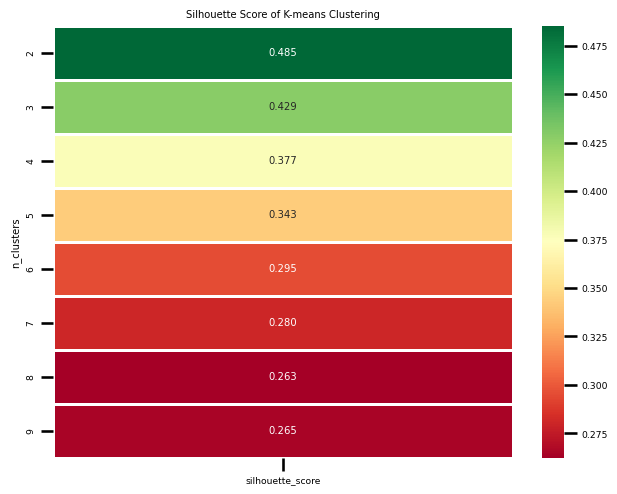

In [61]:
visualize_silhouette_layer(df_scaled)

#### 5.2.3 K-Means Clusters

In [62]:
kmeans = KMeans(n_clusters=2, random_state=142)
kmeans.fit(df_scaled.values)
df_scaled['Cluster'] = kmeans.labels_
df_marketing['Cluster'] = kmeans.labels_

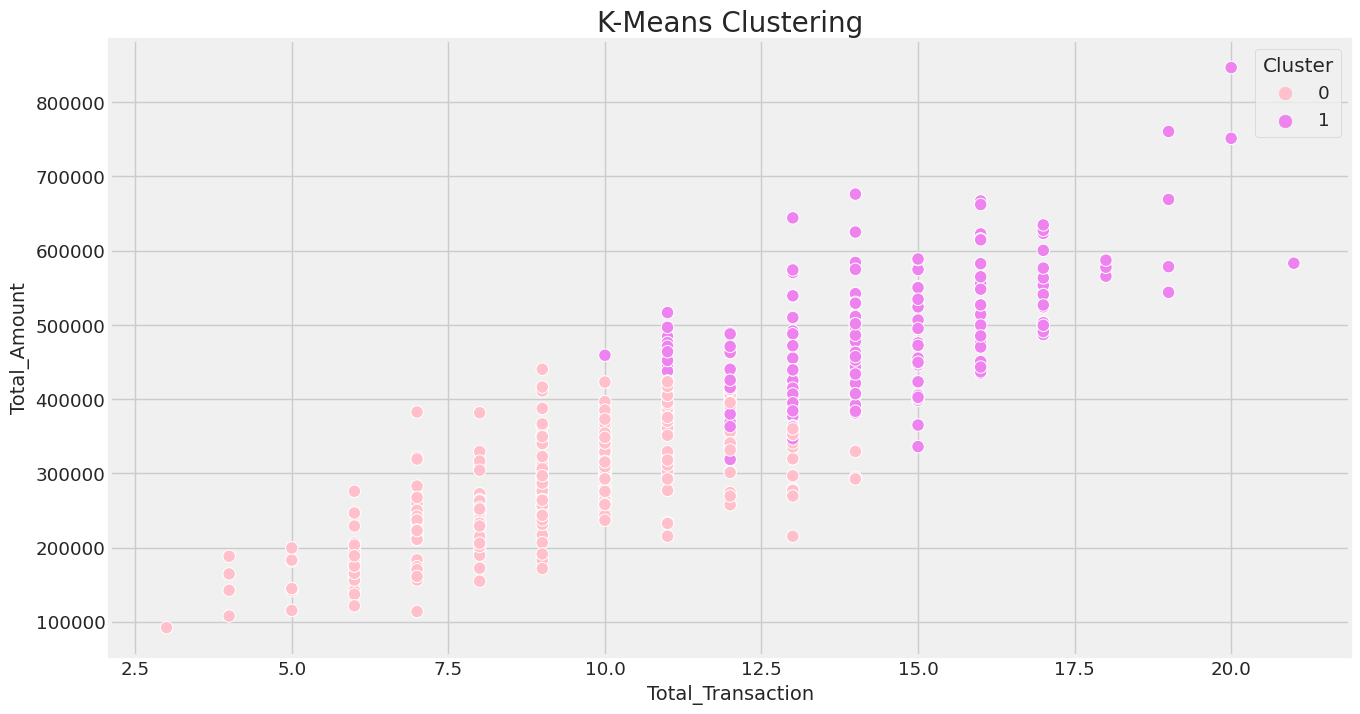

In [63]:
plt.figure(figsize=(16, 8))  
sns.set_context("talk", font_scale=0.8) 
with sns.axes_style("darkgrid"):
    plt.style.use("fivethirtyeight")
    sns.scatterplot(data=df_marketing, x='Total_Transaction', y='Total_Amount', hue='Cluster', palette = ['pink','violet'])
    plt.title('K-Means Clustering', fontsize = 20)

plt.show()

#### 5.2.4 Clustering Analysis

In [64]:
df_marketing.groupby('Cluster')['Total_Transaction','Total_Quantity','Total_Amount'].describe()

Total_Transaction                                                     \
                    count       mean       std   min   25%   50%   75%   max   
Cluster                                                                        
0                   273.0   9.267399  2.129519   3.0   8.0  10.0  11.0  14.0   
1                   174.0  14.310345  2.097675  10.0  13.0  14.0  16.0  21.0   

        Total_Quantity                                                     \
                 count       mean       std   min   25%   50%   75%   max   
Cluster                                                                     
0                273.0  32.974359  7.758492  10.0  28.0  34.0  39.0  47.0   
1                174.0  53.413793  8.262390  37.0  47.0  53.0  58.0  79.0   

        Total_Amount                                                   \
               count           mean           std       min       25%   
Cluster                                                                 
0              273.0  285676.923077  73293.687148   92100.0  236700.0   
1              174.0  483064.367816  87563.246146  318600.0  416800.0   

                                       
              50%       75%       max  
Cluster                                
0        292500.0  341000.0  440200.0  
1        471050.0  530025.0  846700.0

In [65]:
map_cluster = {
    0 : 'High Spender',
    1 : 'Low Spender'
}

df_marketing['Cluster_Mapped'] = df_marketing['Cluster'].map(map_cluster)

In [67]:
df_marketing['Cluster_Mapped'].value_counts()

High Spender    273
Low Spender     174
Name: Cluster_Mapped, dtype: int64

(array([0, 1]), [Text(0, 0, 'Low Spender'), Text(1, 0, 'High Spender')])

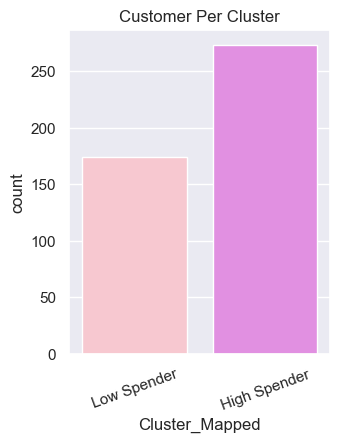

In [68]:
sns.set(rc={'figure.figsize':(3,4)})
sns.countplot(x=df_marketing['Cluster_Mapped'], palette = ['pink','violet'])
plt.title('Customer Per Cluster')
plt.xticks(rotation=20)

The number of customers classified as high spenders is greater than those classified as low spenders.


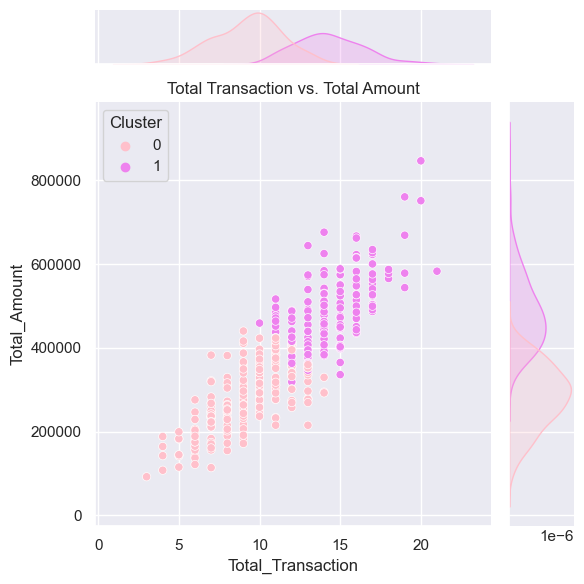

In [69]:
plot = sns.jointplot(x=df_marketing['Total_Transaction'], y=df_marketing['Total_Amount'], hue=df_marketing['Cluster'], palette = ['pink','violet'])
plt.title('Total Transaction vs. Total Amount')
plt.tight_layout()

Text(0.5, 1.0, 'Total Transaction per Cluster')

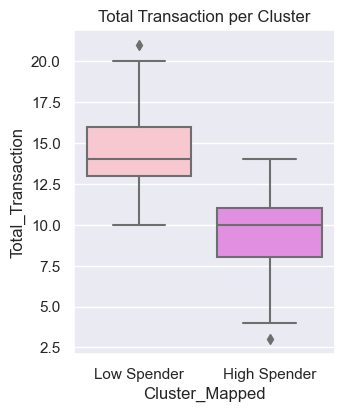

In [70]:
sns.boxplot(x=df_marketing['Cluster_Mapped'], y=df_marketing['Total_Transaction'], palette = ['pink','violet'])
plt.title('Total Transaction per Cluster')

Based on the total transaction boxplot, it can be seen that the data distribution in the low spender category has a higher value compared to the high spender. It indicates that most low spender customers have total transactions greater than most high spender customers.


Text(0.5, 1.0, 'Total Quantity per Cluster')

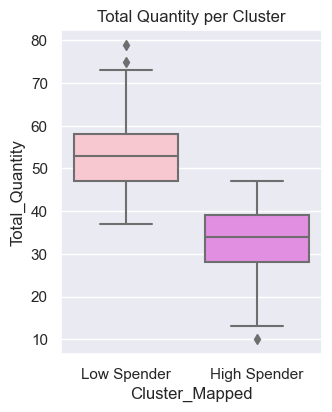

In [71]:
sns.boxplot(x=df_marketing['Cluster_Mapped'], y=df_marketing['Total_Quantity'], palette = ['pink','violet'])
plt.title('Total Quantity per Cluster')

Based on the total quantity boxplot, it can also be seen that the data distribution for low spenders is higher than for high spenders. It shows that most low spender customers tend to buy more goods than high spender customers.


Text(0.5, 1.0, 'Total Amount per Cluster')

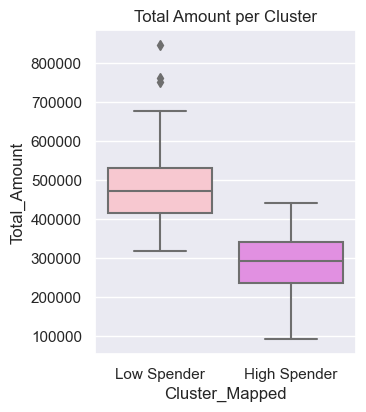

In [72]:
sns.boxplot(x=df_marketing['Cluster_Mapped'], y=df_marketing['Total_Amount'], palette = ['pink','violet'])
plt.title('Total Amount per Cluster')

In terms of the total amount, the boxplot also shows that the distribution in the low spender category is higher than the high spender category. Overall, the total expenditure of low spender customers is higher than that of high spender customers.

## 6. Insight

### 6.1 Inventory Team

Based on the daily time series plot, the total quantity has a highly fluctuating trend during the 2022 period. However, when we examine the monthly time series plot, the data shows an interesting pattern. Total quantity tends to increase in odd months, such as January, March, and so on, but decreases in even months, such as February, April, and so on. This pattern may reflect a seasonal pattern or annual trend that deserves further scrutiny.

When we look at the Boxplot, we can identify the presence of some outliers. These outliers are significant or unusual values that may refer to special events or measurement errors that need to be reviewed. Further analysis of these outliers can provide deeper insight into what factors cause them.

The distribution of total quantity shows a symmetrical pattern. A symmetrical distribution indicates that the data tends to be evenly distributed around its mean value without any significant tendency in any particular direction. It can help us understand the overall behavior of quantities and is a positive indication of the use of statistical models such as ARIMA.

The best ARIMA modeling result for total quantity is ARIMA (1,0,1). The forecasting results were carried out for the 31 day period from January 1 2023 to January 31 2023. The forecasting results show that for the next period the total quantity per day will be around 50.

### 6.2 Marketing Team

Based on the analysis of various data visualizations, a number of insights can be obtained. In the boxplot visualization, it can be seen that the total quantity and total amount of features have several outliers that require special attention. These outliers may indicate situations or events that need further analysis. Meanwhile, distribution visualization shows that the three features have a symmetrical distribution, with total transactions having the lowest skewness, followed by total quantity and total amount.

Further observation of the scatterplot also provides important insights. Total transactions and total quantity have a positive relationship, meaning that the more customers make transactions, the more goods they buy. Apart from that, the scatterplot between total transactions and total amount also shows a positive relationship, which means that the more transactions a customer makes, the total income earned by the company will also increase.

In addition, the results from the Heatmap show that there is a very strong correlation between these three features, with a correlation of 0.9. It indicates that there is a close relationship between these variables. This strong linkage allows the use of clustering techniques to segment customers. With good segmentation, companies can make more informed decisions in designing marketing strategies that suit the characteristics of each customer group, resulting in the potential for significant revenue increases.

The cluster analysis results formed 2 clusters, namely low spenders and high spenders. High spenders have a greater number of customers who are classified as high spenders than the number of customers who are classified as low spenders.
1. Low Spenders

The characteristics of customers classified as Low Spenders are that they make frequent transactions compared to high spenders, buy in total quantities greater than high spenders, and provide a higher total amount for the company than high spenders.

2. High Spenders

Meanwhile, the characteristics of customers classified as high spenders are that they do not make frequent transactions compared to low spenders, buy a smaller total quantity than low spenders, and provide a smaller total amount to the company than low spenders.


## 7. Recommendations

### 7.1 Inventory Team

Recommendations that can be proposed based on the results of the analysis are as follows:

**1.Further analysis**

An interesting pattern in monthly data which tends to increase in odd months and decrease in even months could reflect a seasonal pattern that needs further attention. The inventory team can perform more in-depth analysis to identify the cause of the pattern. For example, is this related to the holiday season or a specific event that impacts demand?

**2. Outlier Analysis**

The existence of outliers in the data is important to pay attention to. The inventory team needs to conduct further analysis of these outliers to understand why. Outliers can indicate issues in the supply chain, policy changes, or other factors that need to be reviewed. Corrective action may be necessary to resolve this issue.

**3. Advanced Forecasting Method**

ARIMA (1,0,1) The model has residuals that meet the white noise assumption but do not meet the normality assumption. It would be better to use other forecasting methods that can consider abnormal residual assumptions such as ARCH or GARCH modeling.

### 7.2 Marketing Team

Recommendations that can be proposed based on the results of the analysis are as follows:

**1. Preparation of Different Marketing Strategies**

Companies can design different marketing strategies for each group. For low spenders, marketing focus can be increasing transaction frequency and promoting products with a higher total quantity. Meanwhile, for high spenders, marketing strategies can focus on improving the total volume and encouraging them to make transactions more frequently.

**2. Product Development and Special Offers**

Companies can develop more exclusive or premium products or services for the high spender cluster, which may be attractive to this group of customers. High spenders may also receive Special offers and incentives to maintain their loyalty. More affordable products or bundle packages may tempt low spenders, while exclusive or premium products may be more attractive to high spenders.

**3. Rewards and Loyalty Programs**

Companies can provide reward and loyalty programs to motivate low spender customers to increase their spending. It can include giving points or special discounts to customers who reach specific targets regarding transactions or quantity.

# Thanks!